# Intro Paragraph
Intro to the topic and short section overview
- Imports and Configs
- Data preprocessing
    - Unneccessary and null value crop
    - Data plot and linear trendline analysis
    - Seasonal breakdown and analysis
    

# Imports and Configurations
Short description of imports and constants



In [680]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import sklearn.preprocessing as prp

from numba import cuda, jit
from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore')
PATH = "Resources/charleston_sealevel_1921_2014.csv"

Short description of why cuda is used
- increased processing power
(note: implement jit tags later on once I realize which functions take longer to execute)

In [681]:
cuda.detect()
print(cuda.gpus)

Found 1 CUDA devices
id 0    b'NVIDIA GeForce RTX 3050 Laptop GPU'                              [SUPPORTED]
                      Compute Capability: 8.6
                           PCI Device ID: 0
                              PCI Bus ID: 1
                                    UUID: GPU-a139b348-32e2-b243-e8ca-607b8e659f9f
                                Watchdog: Enabled
                            Compute Mode: WDDM
             FP32/FP64 Performance Ratio: 32
Summary:
	1/1 devices are supported
<Managed Device 0>


# Data Preprocessing

In [682]:
# Data retrieval
data = pd.read_csv(PATH)
data.head()

,time,depth,latitude,longitude,sea_surface_height_above_reference_level,sensor_type_code
0,UTC,m,degrees_north,degrees_east,millimeters,NaN
1,1921-01-01T12:00:00Z,0.0,32.782,-79.925,NaN,NaN
2,1921-01-02T12:00:00Z,0.0,32.782,-79.925,NaN,NaN
3,1921-01-03T12:00:00Z,0.0,32.782,-79.925,NaN,NaN
4,1921-01-04T12:00:00Z,0.0,32.782,-79.925,NaN,NaN


In [683]:
# Crop unneccessary data, ie everything but the numerical time and sea surface height values
data.drop(columns=["depth", "latitude", "longitude", "sensor_type_code"], inplace=True)
data.drop([0], inplace=True)
data.rename(columns={"sea_surface_height_above_reference_level": "sea level"}, inplace=True)
data.head()


,time,sea level
1,1921-01-01T12:00:00Z,NaN
2,1921-01-02T12:00:00Z,NaN
3,1921-01-03T12:00:00Z,NaN
4,1921-01-04T12:00:00Z,NaN
5,1921-01-05T12:00:00Z,NaN


In [684]:
# Inspect and convert data types
print("Initial data types: ")
data.dtypes

Initial data types: 


time         object
sea level    object
dtype: object

In [685]:
data["time"] = pd.to_datetime(data["time"])
data["sea level"] = pd.to_numeric(data["sea level"])
print("New data types: ")
data.dtypes

New data types: 


time         datetime64[ns, UTC]
sea level                float64
dtype: object

**Null value processing**

Null values can cause issues with visualization or artificially skew certain observations.

In [686]:
# Inspect noticeable null values in dataset
valid_data = (
    pd.DataFrame(data.notna().sum())
        .rename(columns={0: "Valid Entries"})
        .reset_index()
)

nan_data = (
    pd.DataFrame(data.isna().sum())
        .rename(columns={0: "NaN Entries"})
        .reset_index()
)

validity_data = valid_data.merge(nan_data, on='index', how='inner')

validity_data["NaN Percentage"] = (
    validity_data["NaN Entries"]
    /len(data) * 100
)

validity_data["NaN Percentage"] = round(validity_data["NaN Percentage"], 3)

validity_data.head()


,index,Valid Entries,NaN Entries,NaN Percentage
0,time,34333,0,0.000
1,sea level,33529,804,2.342


<Axes: title={'center': 'NaN Value Presence in Sea Level Data'}>

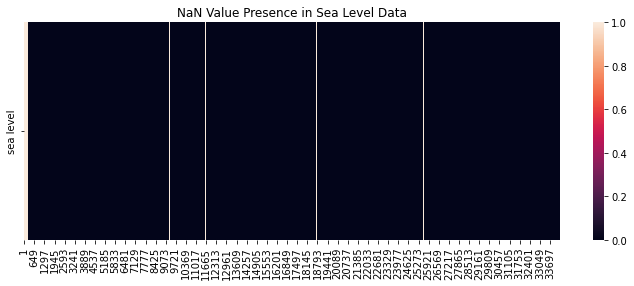

In [687]:
# Visualize location of missing sea level data points
sea_level_data = data[["sea level"]].copy()

plt.figure(figsize=(12, 4))
plt.title("NaN Value Presence in Sea Level Data")

sns.heatmap(sea_level_data.isna().T)


In [688]:
def plot_trendline(df, title, xlabel, ylabel, deg, label="value"): 
    """Plots dataframe with polynomial trendline, returns value change data based on trendline"""
    plt.figure(figsize=(18, 5))

    # Make plot of dataset
    sns.lineplot(x=df.index, y=df.value, label=label)

    # Create trendline
    x = range(0, len(df))
    z = np.polyfit(x, y=df.value, deg=deg)
    f = np.poly1d(z)

    plt.title(title, fontsize=20, pad=10)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.plot(df.index, f(x), c="#000000", ls="-")

    difference = round(f(len(df)) - f(0), 2)
    return difference
    

Net Sea Level Change: 297.52 mm
Yearly Sea Level Change: 3.17 mm


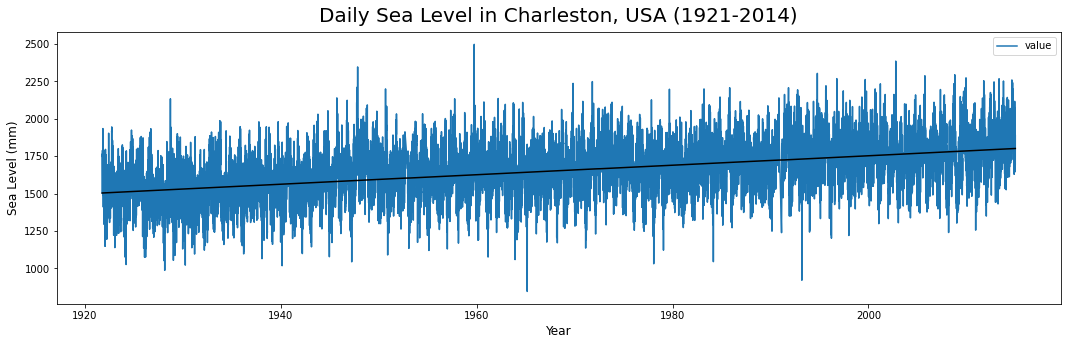

In [689]:
plot_data = data.dropna()
# Convert datetime values to yearly numerical ones
plot_data["year"] = plot_data["time"].dt.year
plot_data = plot_data.set_index(["time"])
plot_data = plot_data.rename(columns={"sea level": "value"})

difference = plot_trendline(plot_data, "Daily Sea Level in Charleston, USA (1921-2014)", 
                            "Year", "Sea Level (mm)", 1)

years = plot_data["year"].unique().size
incr_change = round(difference/years, 2)

print("Net Sea Level Change: {} mm".format(difference))
print("Yearly Sea Level Change: {} mm".format(incr_change))

Net Sea Level Change: 113.29 mm
Yearly Sea Level Change: 8.09 mm


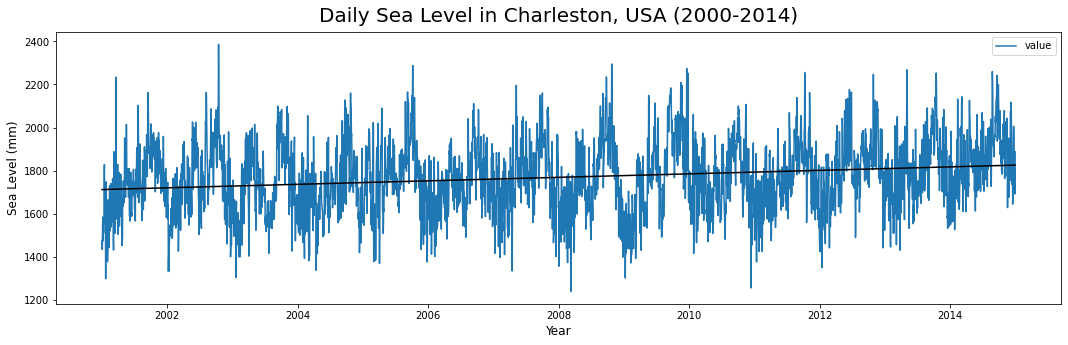

In [690]:
# Plotting smaller subsection of data for trend analysis
recent_plot_data = plot_data[plot_data["year"] > 2000]

difference = plot_trendline(recent_plot_data, 
                            "Daily Sea Level in Charleston, USA (2000-2014)",
                            "Year", "Sea Level (mm)", 1)

years = recent_plot_data["year"].unique().size
incr_change = round(difference/years, 2)

print("Net Sea Level Change: {} mm".format(difference))
print("Yearly Sea Level Change: {} mm".format(incr_change))

**Seasonal Decomposition**

Based on the generated data plots, the sea level seems to behave in a seasonal pattern (ie varies based on the time of the year). Breaking down the data into seasonal components (level, trend, seasonality, noise) can help select appropriate forecasting methods. 

In [691]:
def convert_to_monthly(df): 
    """Converts dataframe to use monthly entries"""
    monthly_data = df.resample("M").mean()
    monthly_data.reset_index(inplace=True)
    monthly_data["time"] = monthly_data["time"].dt.to_period("M")
    monthly_data = monthly_data.set_index("time")
    # Fills NaN values in case some are still present
    monthly_data.interpolate(inplace=True)
    monthly_data.index = monthly_data.index.to_timestamp()
    
    return monthly_data

def plot_seasonal(df, model_type): 
    """Creates seasonal decomposition plot of dataframe"""
    plt.rc("figure", figsize=(14,7))
    result = seasonal_decompose(df["value"], model=model_type)
    result.plot()
    


In [692]:
monthly_lt_data = convert_to_monthly(plot_data)
monthly_st_data = convert_to_monthly(recent_plot_data)

monthly_lt_data.head()

,value,year
time,,
1921-10-01,1669.533333,1921.0
1921-11-01,1573.766667,1921.0
1921-12-01,1533.225806,1921.0
1922-01-01,1421.516129,1922.0
1922-02-01,1478.607143,1922.0


Seasonal Decomposition of Monthly Sea Level (1921 - 2004) - Additive Model


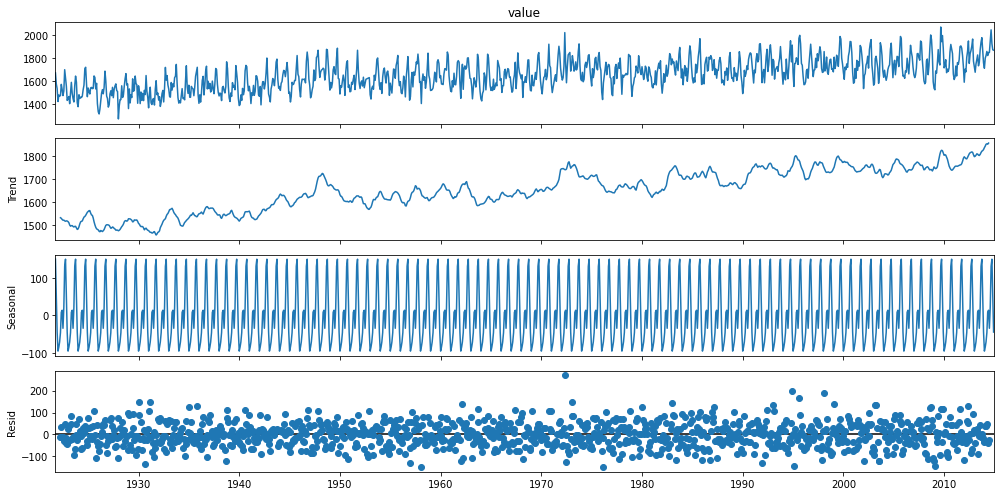

In [693]:
plot_seasonal(monthly_lt_data, "additive")
print("Seasonal Decomposition of Monthly Sea Level (1921 - 2004) - Additive Model")

Seasonal Decomposition of Monthly Sea Level (2000 - 2004) - Additive Model


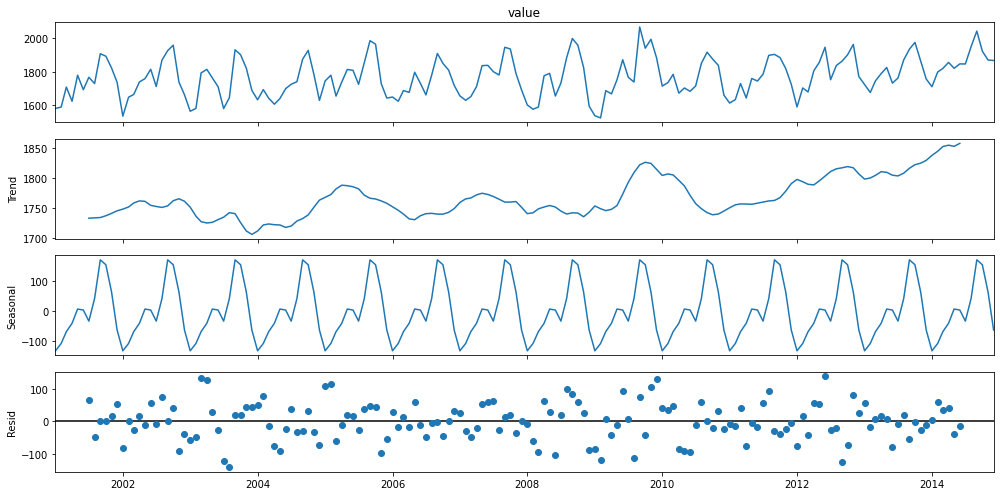

In [694]:
plot_seasonal(monthly_st_data, "additive")
print("Seasonal Decomposition of Monthly Sea Level (2000 - 2004) - Additive Model")

Seasonal Decomposition of Monthly Sea Level (1921 - 2004) - Multiplicative Model


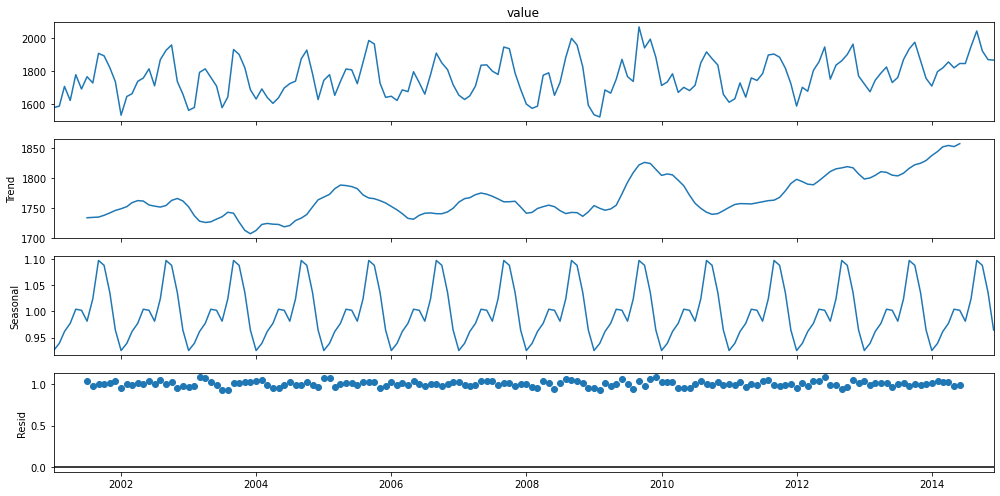

In [695]:
plot_seasonal(monthly_st_data, "multiplicative")
print("Seasonal Decomposition of Monthly Sea Level (1921 - 2004) - Multiplicative Model")

**Seasonal Decomposition - Results Analysis**

Some conclusions can be made based on the result graphs produced above and those produced earlier in the analysis: 
1. The data trends upwards throughout the entire time period, and seems to increase at a faster pace near the end of the dataset (yearly sea level change of +3.17mm/year globally, and of +8.09mm/year for the 10 most recent years)
2. The data varies cyclically every year - seems to reach its lowest point around January of every year and peak around September
3. The data best fits an additive model - Although it trends upwards and cyclically, the residual data is much better fit on the additive seasonal data models than the multiplicative one. 

**Encoding Data**

Due to the presence of invalid values in ~1991 (and earlier), and the change in increase speed seen in the more recent data, the model will be built on data from 2000-2014. To ease modeling cyclic trends, the time data will also be converted into a one-hot encoding. 

In [696]:
# Subset of data from 2000-2014
data["year"] = data["time"].dt.year
model_data = data[data["year"] >= 2000]

model_data = model_data.reset_index()
model_data.drop(columns=["index", "year"], inplace=True)
model_data = model_data.set_index(["time"])
model_data = model_data.rename(columns={"sea level": "value"})
model_data.tail(5)

,value
time,
2014-12-27 12:00:00+00:00,1813.0
2014-12-28 12:00:00+00:00,1752.0
2014-12-29 12:00:00+00:00,1692.0
2014-12-30 12:00:00+00:00,1789.0
2014-12-31 12:00:00+00:00,1888.0


In [697]:
# Convert univariate (time - sea level) series into multivariate (day - week - month - sea level)

data_features = (
    model_data
    .assign(day = model_data.index.day)
    .assign(month = model_data.index.month)
    .assign(year = model_data.index.year)
)

def onehot_encode(df, cols): 
    """Makes a one-hot encoding for select cols in dataframe"""
    for col in cols: 
        indicators = pd.get_dummies(df[col], prefix=col, dtype=int)
        df = pd.concat([df, indicators], axis=1)
    return df

data_features = onehot_encode(data_features, ["day", "month", "year"])

# Set empty cols for predicting future values
data_features["year_2015"], data_features["year_2016"] = 0, 0



In [698]:
def generate_cyclical_features(df, col_name, period, start_num=0): 
    """Generates sin and cos features for time increments"""
    kwargs = {
        f'sin_{col_name}' : lambda x: np.sin(2*np.pi*(df[col_name]-start_num)/period),
        f'cos_{col_name}' : lambda x: np.cos(2*np.pi*(df[col_name]-start_num)/period)
    }

    return df.assign(**kwargs).drop(columns=[col_name])

data_features = generate_cyclical_features(data_features, "day", 31, 1)
data_features = generate_cyclical_features(data_features, "month", 12, 1)


**Splitting Data**

The data will now be split into 3 subsets: 
- Training data: A majority of the time series used for training the model. The data at the end of the series is left out (to eventually be tested on).
- Validation data: A small subsection of the end of the training data series. Used to analyse and tune the hyperparameters that configure the model.
- Testing data: The end of the time series not used in the training/validation set. Used to test the performance of the model on "new" data it has not seen. 

The data will also be scaled to fit a fixed range [0, 1] to normalize high values. A MinMax transformation will be calculated and applied through scikit's fit() and transform() functions, respectively. 

In [699]:
def split_feature(df, col): 
    """Extracts a specific column from dataframe"""
    col_df = df[[col]]
    no_col_df = df.drop(columns=[col])
    return no_col_df, col_df


def split_data(df, target_col, test_ratio): 
    """Splits a df's data into train, validation and test data. Target data should be inputted as target_col"""
    validation_ratio = test_ratio / (1 - test_ratio)
    x, y = split_feature(df, target_col)
    # Shuffling omitted to maintain time series validity
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_ratio, shuffle=False)
    _,  x_val, _, y_val = train_test_split(x_train, y_train, test_size=validation_ratio, shuffle=False)
    
    return x_train, x_val, x_test, y_train, y_val, y_test

x_train, x_val, x_test, y_train, y_val, y_test = split_data(data_features, "value", 0.2)
print("""New Data Dimensions (rows, columns) : 
      Training data: x - {}, y - {}
      Validation data: x - {}, y - {}
      Testing data: x - {}, y - {}"""
      .format(x_train.shape, y_train.shape, 
              x_val.shape, y_val.shape, 
              x_test.shape, y_test.shape))


New Data Dimensions (rows, columns) : 
      Training data: x - (4383, 65), y - (4383, 1)
      Validation data: x - (1096, 65), y - (1096, 1)
      Testing data: x - (1096, 65), y - (1096, 1)


In [700]:
# Convert dataframes to scaled Numpy arrays
x_scaler = prp.MinMaxScaler()
y_scaler = prp.MinMaxScaler()
# Predictors
scaled_x_train = x_scaler.fit_transform(x_train)
# Transforms validation and test data under the same fit params as training data
scaled_x_val = x_scaler.transform(x_val)
scaled_x_test = x_scaler.transform(x_test)

# Target vars
scaled_y_train = y_scaler.fit_transform(y_train)
scaled_y_val = y_scaler.transform(y_val)
scaled_y_test = y_scaler.transform(y_test)

print(scaled_x_train)

[[0.         1.         0.         ... 1.         0.5        1.        ]
 [0.         0.         1.         ... 0.98973865 0.5        1.        ]
 [0.         0.         0.         ... 0.95937469 0.5        1.        ]
 ...
 [1.         0.         0.         ... 0.91015123 0.25       0.9330127 ]
 [1.         0.         0.         ... 0.95937469 0.25       0.9330127 ]
 [1.         0.         0.         ... 0.98973865 0.25       0.9330127 ]]


**Loading Data**

Data must be split into batches to train the RNN model, which can be done with the Pytorch.DataLoader class. The whole process involves: 
1. Convert data to tensors (multi-dimensional matrices)
2. Wrap the tensors into datasets (divided by train, validation and test)
3. Convert datasets to DataLoaders (where params like "shuffle" are specified)

In [701]:
# Define nb. of entries to train at a time (kept as power of 2 to maximize GPU processing, multiple values tested)
BATCH_SIZE = 32

# Convert data to tensors
train_features = torch.Tensor(scaled_x_train)
train_targets = torch.Tensor(scaled_y_train)
val_features = torch.Tensor(scaled_x_val)
val_targets = torch.Tensor(scaled_y_val)
test_features = torch.Tensor(scaled_x_test)
test_targets = torch.Tensor(scaled_y_test)

# Convert tensors to datasets
train_dataset = TensorDataset(train_features, train_targets)
val_dataset = TensorDataset(val_features, val_targets)
test_dataset = TensorDataset(test_features, test_targets)

# Convert datasets to DataLoaders
train_dl = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)
val_dl = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)
test_dl = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)


# Model Creation

**LSTM Model Classes Creation**

Classes will be defined to facilitate the creation and training processes of the model. The LSTMModel class will help define and tune hyperparameters for the model, while the Optimizer class will help with (fill in).

Source for LSTMModel class implementation: https://www.educative.io/answers/how-to-build-an-lstm-model-using-pytorch

**Sources**

https://www.educative.io/answers/how-to-build-an-lstm-model-using-pytorch

https://www.kaggle.com/code/kevinwibowo/sea-level-rise-prediction-with-pytorch

https://www.analyticsvidhya.com/blog/2021/04/difference-between-fit-transform-fit_transform-methods-in-scikit-learn-with-python-code/

